In [1]:
from pybioportal import clinical_data as cd

In [2]:
surv_data = cd.fetch_all_clinical_data_in_study(study_id="brca_tcga",
                                                attribute_ids=["OS_STATUS", "OS_MONTHS", "RACE"],
                                                clinical_data_type="PATIENT", ret_format="WIDE")

In [3]:
# Elimina valori nan e negativi
surv_data.dropna(subset=["OS_MONTHS"], inplace=True)
surv_data.dropna(subset=["OS_STATUS"], inplace=True)

# Coversione valori decimali per la sopravvivenza
surv_data["OS_MONTHS"] = surv_data["OS_MONTHS"].astype(float)

# Eliminazione valori negativi
surv_data = surv_data[surv_data["OS_MONTHS"] >= 0]

# Conversione valori binari per l'evento
surv_data["OS_STATUS"] = surv_data["OS_STATUS"].map({"0:LIVING": 0, "1:DECEASED": 1})

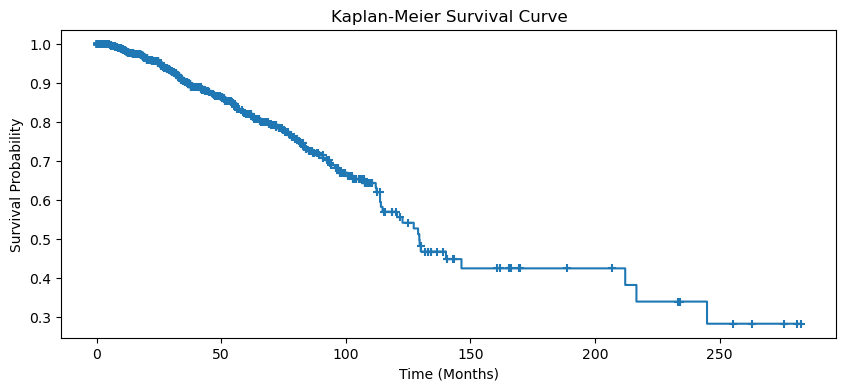

In [16]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt


# Inizializzazione del fitter di Kaplan-Meier
kmf = KaplanMeierFitter()

# Fitting del modello Kaplan-Meier utilizzando la colonna OS_MONTHS
kmf.fit(surv_data["OS_MONTHS"], event_observed=surv_data["OS_STATUS"])

plt.figure(figsize=(10,4))

# Plot della curva di sopravvivenza
ax = kmf.plot(ci_show=False)
# Identificazione dei valori censurati e visualizzazione dei simboli con dimensioni personalizzate
censored_times = surv_data[surv_data['OS_STATUS'] == False]['OS_MONTHS']  # Tempi censurati
censored_probs = kmf.survival_function_.loc[censored_times].values.flatten()  # Probabilità di sopravvivenza
ax.scatter(censored_times, censored_probs, marker='+', s=30)

plt.title("Kaplan-Meier Survival Curve")
plt.xlabel("Time (Months)")
plt.ylabel("Survival Probability")
plt.legend().remove()
plt.show()